## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [30]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from helper import project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [43]:
## load universe_factors
fundamental_df = pd.read_csv('fundamental_20170405_20230317.csv').iloc[:,1:]
universe = pd.read_csv('all_20170405_20230327.csv')
universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d')
universe.set_index(['date'],inplace=True)
print(fundamental_df.shape, universe.shape)

(468, 5) (435518, 64)


In [44]:
print(len(universe.columns),universe.columns)

64 Index(['ts_code', 'trade_date', 'turnover_rate', 'amount', 'pe', 'pb',
       'total_share', 'total_mv', 'volume', 'open', 'close', 'high', 'low',
       'cci', 'name', 'industry', 'list_date', 'issue_price', 'issue_amount',
       'type', 'type_value', 'p_change_min', 'p_change_max', 'cfps',
       'revenue_ps', 'quick_ratio', 'dt_eps', 'basic_eps_yoy', 'dt_eps_yoy',
       'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt', 'q_dt_roe',
       'roe_yoy', 'capital_rese_ps', 'surplus_rese_ps', 'gross_margin',
       'interestdebt', 'ca_to_assets', 'ebt_yoy', 'or_yoy', 'equity_yoy',
       'alpha_close2open', 'supertrend', 'close_5_sma', 'close_20_sma',
       'turnover_rate_5_sma', 'log-ret', 'atr_5', 'cci_6', 'vwma_2', 'vwma_25',
       'close_10_kama_2_30', 'close_10_kama_5_30', 'close_2_kama',
       'alpha_close2open_5_sma', 'alpha_close2open_25_sma', 'alpha_supertrend',
       'alpha_cci', 'alpha_kama', 'alpha_skew2sentiment', 'alpha_fundamental'],
      dtype='object')


### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [45]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4, '互联网':5, '软件服务':6}

all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,amount,pe,pb,total_share,total_mv,volume,open,...,alpha_cci,alpha_kama,alpha_skew2sentiment,alpha_fundamental,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6
date,,,,,,,,,,,,,,,,,,,,,
2017-04-05,600479.SH,20170405,2.006193,-0.480007,1.112067,-0.395205,34875.5931,-1.039951,12209.193680,10.24854,...,2.006193,0.739408,-0.674014,-0.919590,False,False,True,False,False,False
2017-04-05,000423.SZ,20170405,0.210542,2.403536,-1.180883,0.977043,65402.1537,1.613743,10412.673976,59.47142,...,0.210542,-3.089506,-2.736492,-0.646736,False,False,True,False,False,False
2017-04-05,000513.SZ,20170405,0.440841,0.031551,0.047100,0.165895,42559.6852,0.306894,9571.387024,21.61153,...,0.440841,-0.025958,0.444410,0.951135,False,False,True,False,False,False
2017-04-05,000623.SZ,20170405,0.998129,1.577648,-2.201527,-1.765818,89443.8433,0.493442,22175.215591,21.52812,...,0.998129,-0.174221,0.122342,-0.090217,False,False,True,False,False,False
2017-04-05,300108.SZ,20170405,-0.294759,-1.017406,-0.141022,-0.502209,63601.4674,-1.049965,3797.204914,8.66723,...,-0.294759,0.681508,1.770367,-0.228329,False,False,True,False,False,False


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [46]:
quantile_jud = all_factors['log-ret'].quantile([0.3,0.2,0.5])
quantile_jud

0.3   -0.011580
0.2   -0.019073
0.5    0.000000
Name: log-ret, dtype: float64

In [47]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<-0.01, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>0, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [48]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
#all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-5).fillna(0).astype(np.int16)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-5)

all_factors = all_factors.dropna()
all_factors['target'] = all_factors['target'].astype(np.int16)

universe = universe.loc[universe['trade_date']<20230317]
all_factors = all_factors.loc[all_factors['trade_date']<20230317]

In [49]:
all_factors['target'].unique()

array([ 0,  1, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

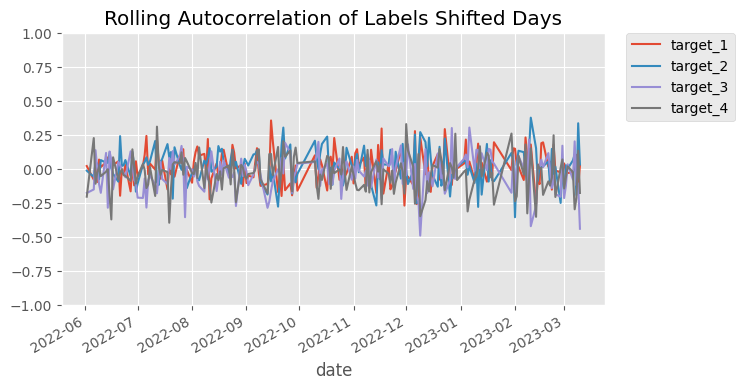

In [50]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220601]
ph.IID_check(tmp)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [51]:
# 'total_mv' not add
features = ['turnover_rate', 'atr_5', 'pe', 'pb', 'revenue_ps', 'total_mv',
       #'dt_eps_yoy', 'bps_yoy', 'roe_yoy', 'ebt_yoy', 'or_yoy', 'equity_yoy',
       'alpha_cci', 'alpha_supertrend', 'alpha_kama', 'alpha_close2open_5_sma',
       'alpha_close2open_25_sma', 'alpha_skew2sentiment', 'alpha_fundamental']+ sector_columns

target_label = 'target'

# for col in features:
#     if all_factors[col].isnull().any():
#         print(col)
        
# if all_factors[target_label].isnull().any():
#     print(target_label)
# all_factors = all_factors.fillna(0.)
# all_factors.sort_index(inplace=True)

In [52]:
#all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
#all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
#all_factors.shape
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date'])
all_factors.head()

trade_date  turnover_rate    amount        pe        pb  \
date       ts_code                                                              
2017-04-05 600479.SH    20170405       2.006193 -0.480007  1.112067 -0.395205   
           300078.SZ    20170405       1.695639  0.170208  1.386403  1.274709   
           002279.SZ    20170405       1.763086 -0.358572  0.514769  0.589977   
           002368.SZ    20170405      -0.892074 -0.568614  0.093311  1.066828   
           002410.SZ    20170405       0.021571  0.173572 -0.003909  1.671853   

                      total_share  total_mv        volume      open     close  \
date       ts_code                                                              
2017-04-05 600479.SH   34875.5931 -1.039951  12209.193680  10.24854  10.30447   
           300078.SZ   44882.5186 -0.592683  18611.624439  12.71329  13.42654   
           002279.SZ   54149.1950 -0.662495   9776.308895  14.22015  14.65664   
           002368.SZ   41559.7227 -0.438173   4879.249491  20.97437  20.68836   
           002410.SZ  111936.1939  0.012633  17158.250099  14.93654  14.60334   

                      ...  alpha_skew2sentiment  alpha_fundamental  sector_1  \
date       ts_code    ...                                                      
2017-04-05 600479.SH  ...             -0.674014          -0.919590     False   
           300078.SZ  ...              0.384397          -1.053992     False   
           002279.SZ  ...              0.220088          -0.816266     False   
           002368.SZ  ...             -0.254336          -0.276151     False   
           002410.SZ  ...              0.130452          -0.966414     False   

                     sector_2 sector_3  sector_4  sector_5  sector_6  \
date       ts_code                                                     
2017-04-05 600479.SH    False     True     False     False     False   
           300078.SZ    False    False     False     False      True   
           002279.SZ    False    False     False     False      True   
           002368.SZ    False    False     False     False      True   
           002410.SZ    False    False     False     False      True   

                     return_2q  target  
date       ts_code                      
2017-04-05 600479.SH         0       0  
           300078.SZ         0      -1  
           002279.SZ         0      -1  
           002368.SZ         0      -1  
           002410.SZ         0      -1  

[5 rows x 71 columns]

In [53]:
tmp = all_factors.dropna().copy()
print(tmp.shape)
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_test.head()

(432841, 71)


turnover_rate     atr_5        pe        pb  revenue_ps  \
date       ts_code                                                              
2021-12-31 002279.SZ      -0.666901 -0.780429 -0.328278  0.102415   -0.171042   
           600406.SH      -0.817335  0.709805 -0.332404  1.015665    0.003466   
           600271.SH      -0.684164 -0.636570 -0.416459 -0.899091    0.315450   
           300845.SZ       2.146519  0.078828 -0.377376 -0.343706   -0.249346   
           300935.SZ      -0.471012  0.102058 -0.289330 -0.273305   -0.204322   

                      total_mv  alpha_cci  alpha_supertrend  alpha_kama  \
date       ts_code                                                        
2021-12-31 002279.SZ -0.389112  -0.666901         -0.152966    0.318082   
           600406.SH  9.292557  -0.817335          0.019579   -1.677659   
           600271.SH  0.561046  -0.684164         -0.026300    0.510560   
           300845.SZ -0.435342   2.146519          0.054709   -0.553768   
           300935.SZ -0.397955  -0.471012         -0.066461   -1.005824   

                      alpha_close2open_5_sma  alpha_close2open_25_sma  \
date       ts_code                                                      
2021-12-31 002279.SZ               -0.319346                -0.429838   
           600406.SH                1.288256                 0.866675   
           600271.SH               -0.175415                -0.209743   
           300845.SZ                0.288597                 1.502641   
           300935.SZ               -0.064960                -0.471192   

                      alpha_skew2sentiment  alpha_fundamental  sector_1  \
date       ts_code                                                        
2021-12-31 002279.SZ             -0.013900          -0.384313     False   
           600406.SH             -0.302531           0.005823     False   
           600271.SH             -0.006177          -0.057851     False   
           300845.SZ              2.428018          -0.157201     False   
           300935.SZ              0.446287          -0.147379     False   

                      sector_2  sector_3  sector_4  sector_5  sector_6  
date       ts_code                                                      
2021-12-31 002279.SZ     False     False     False     False      True  
           600406.SH     False     False     False     False      True  
           600271.SH     False     False     False     False      True  
           300845.SZ     False     False     False     False      True  
           300935.SZ     False     False     False     False      True

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [54]:
n_days = 10
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    'min_samples_split' : 1000,
    #'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [100, 200, 300, 400]

### Pick Important Features by Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 4/4 [06:17<00:00, 94.26s/Model]


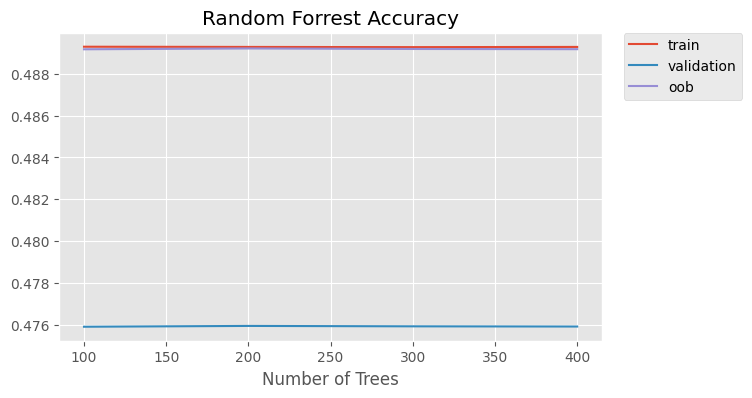

Features Ranked by Average Importance:

      Feature                     Importance
 1. alpha_cci               (0.1562114803914887)
 2. turnover_rate           (0.15458985532188238)
 3. atr_5                   (0.12066433041387249)
 4. pe                      (0.07335629364783197)
 5. alpha_fundamental       (0.0675902951729963)
 6. pb                      (0.06303813165621132)
 7. alpha_supertrend        (0.051148422613843725)
 8. alpha_kama              (0.04934094508948021)
 9. sector_6                (0.04544823458708845)
10. alpha_close2open_25_sma (0.0408852855943409)
11. alpha_close2open_5_sma  (0.039760250185474307)
12. sector_3                (0.03923800991958337)
13. alpha_skew2sentiment    (0.03715904216696232)
14. sector_5                (0.03568502335301624)
15. sector_2                (0.01283058558061733)
16. sector_1                (0.009184720116733566)
17. sector_4                (0.0038690941885764383)


In [23]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

#### Results
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [86]:
factor_names = [
    'alpha_fundamental',
    'alpha_cci',
    'alpha_kama',
    'alpha_supertrend',
    'alpha_skew2sentiment',
    'turnover_rate',
    'atr_5'
]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2).fillna(method='ffill')
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

ts_code,000028.SZ,000034.SZ,000150.SZ,000153.SZ,000411.SZ,000423.SZ,000513.SZ,000555.SZ,000597.SZ,000623.SZ,...,688619.SH,688639.SH,688656.SH,688658.SH,688670.SH,688687.SH,688739.SH,688777.SH,688787.SH,688799.SH
date,,,,,,,,,,,,,,,,,,,,,
2017-04-05,NaN,NaN,NaN,NaN,NaN,59.10879,22.32295,NaN,NaN,21.39361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-06,NaN,NaN,NaN,NaN,NaN,57.44069,22.01531,NaN,NaN,21.00425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-07,NaN,NaN,NaN,NaN,NaN,56.84235,22.04223,NaN,NaN,21.04673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-10,NaN,NaN,NaN,NaN,NaN,56.47972,22.47292,NaN,NaN,20.85559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-11,NaN,NaN,NaN,NaN,NaN,57.67640,22.53445,NaN,NaN,20.98301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [33]:
n_days = 20
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    'min_samples_split' : 1000,
    #'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [20, 50, 300]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 3/3 [02:28<00:00, 49.51s/Model]


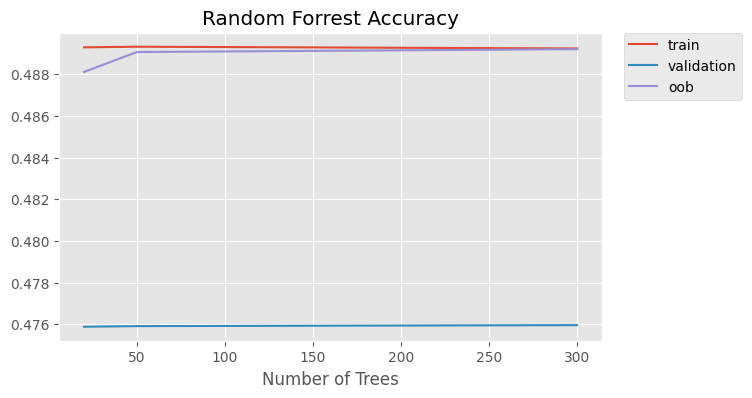

In [34]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.4759542458095229
Precision score:  0.4759542458095229
Recall score:  0.4759542458095229
F1 score:  0.4759542458095229


### Evalueate alpha factor

In [36]:
import alphalens as al

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1, 0, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

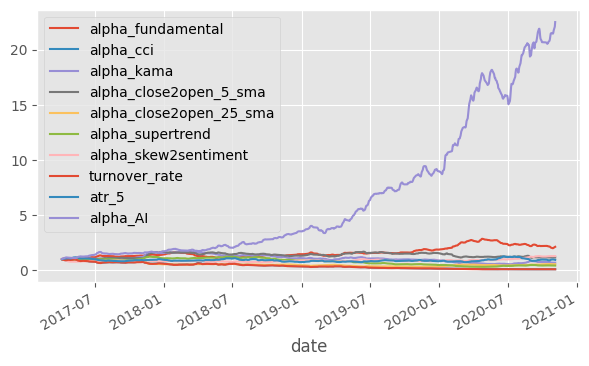

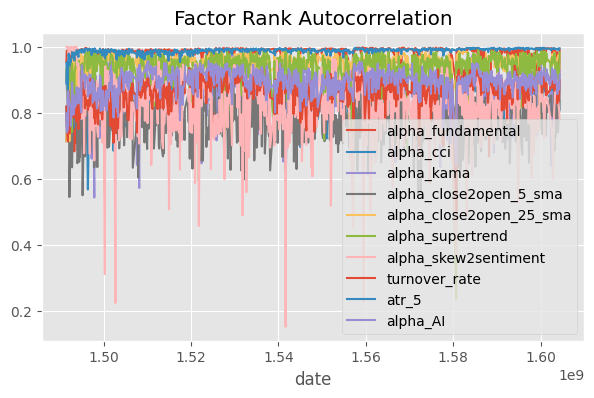

In [37]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

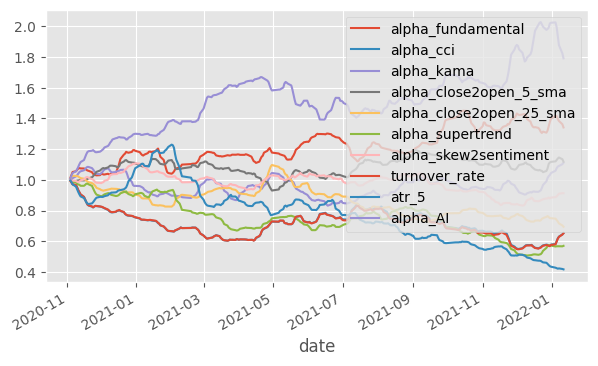

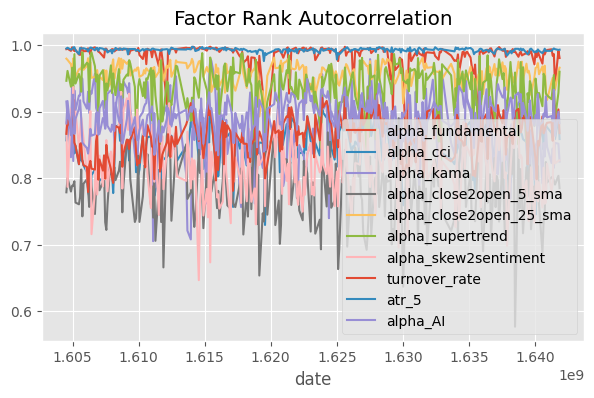

In [38]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [56]:
n_days = 3
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    'min_samples_split' : 1000,
    #'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 250

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [57]:
print(train_score)
print(valid_score, oob_score)

[0.48924021534400164]
[0.4749058607704934] [0.48424887163861985]


### View Train Set Results

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

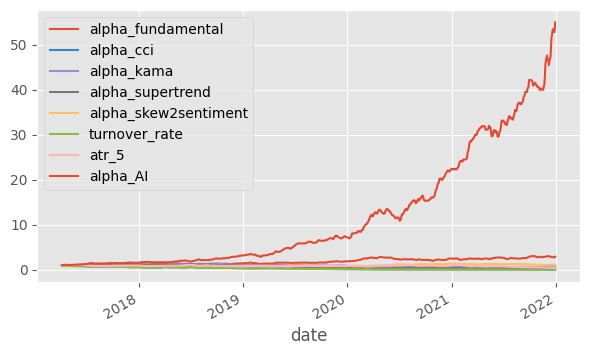

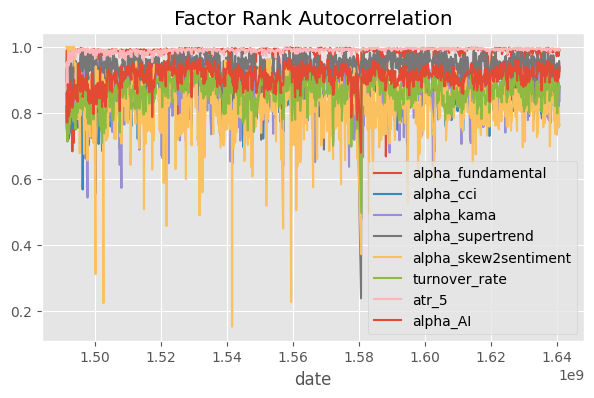

In [89]:
show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

In [81]:
y_tmp = y_test.loc[y_test.index.get_level_values(0)<'2023-03-10']
X_tmp = X_test.loc[X_test.index.get_level_values(0)<'2023-03-10']

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

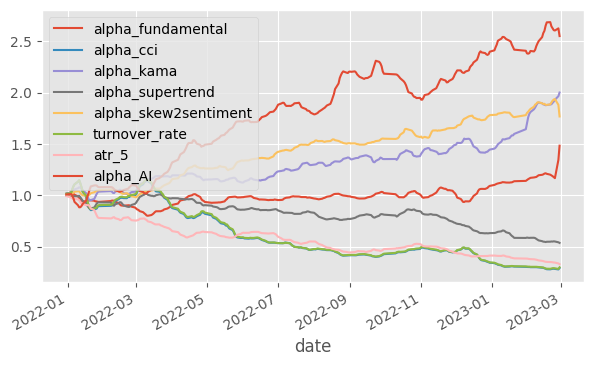

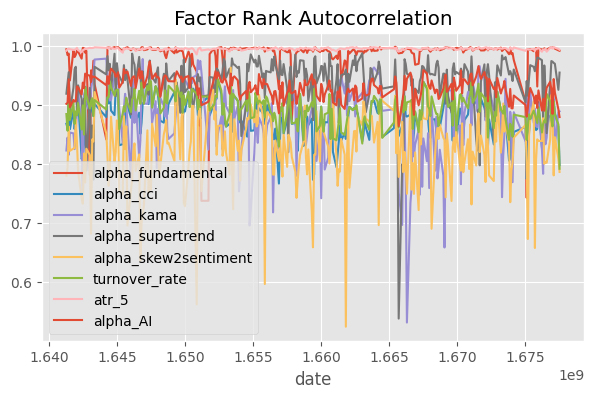

In [88]:
tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2).fillna(method='ffill')
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')
show_sample_results(all_factors, X_tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [90]:
# shift data
#all_factors = universe.copy(deep=True)
# predict 2days
#all_factors['alpha_cci'] = all_factors.groupby('ts_code')['alpha_cci'].shift(2)
#all_factors['alpha_fundamental'] = all_factors.groupby('ts_code')['alpha_fundamental'].shift(5)
#all_factors = all_factors.fillna(method='bfill')
all_factors = all_factors.reset_index().set_index(['date', 'ts_code'])

In [91]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    return factors_with_alpha
    
all_factors = save_AI_factors(all_factors, clf_nov)
all_factors = all_factors.reset_index().set_index(['date'])
all_factors = universe.merge(all_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[0.13964612 0.10603349 0.08693893 ... 0.22851777 0.14361472 0.20234032] 432841


In [ ]:
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret', 'return_2q', 
       'alpha_close2open', 'alpha_close2open_5_sma', 'alpha_close2open_25_sma', 
       'alpha_supertrend', 'alpha_cci', 'close_2_kama', 'alpha_kama', 'alpha_skew2sentiment',
       'alpha_fundamental','alpha_AI']
all_factors[field].to_csv('factors_AI_20170405_20230317.csv')

In [73]:
tmp = all_factors[field]
#tmp = tmp.loc[tmp.industry=='化学制药']
tmp = tmp.loc[tmp['trade_date']>20220501]
tmp.to_csv('factor_tmp.csv')